## Auto encoder

In [1]:
import scipy.io
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping 

from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
mat = scipy.io.loadmat('/content/drive/My Drive/ML4DM_data/SUB_100307_S2.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'D', 'SR', 'class_label', 'time_vect'])


In [3]:
D = mat['D']
print(D.shape)
D2 = D.reshape(D.shape[0], -1)
print(D2.shape)
D2_scaled = StandardScaler().fit_transform(D2)

(240, 2035, 124)
(240, 252340)


In [4]:
labels = mat['class_label']
print(labels.shape)

(124, 1)


In [5]:
pca = PCA(.95)
pca.fit(D2_scaled)
print("Components = ", pca.n_components_)
data_pca = pca.transform(D2_scaled)
print(data_pca.shape)
reprojection = data_pca@pca.components_
print(reprojection.shape)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(D2_scaled, reprojection)
print("RMSE = ", np.sqrt(mse))

Components =  85
(240, 85)
(240, 252340)
RMSE =  0.22309658735769633


# Auto encoder

In [6]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


AUTOENCODER STRUCTURE:
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 252340)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)                21448985  
_________________________________________________________________
dense_4 (Dense)              (None, 252340)            21701240  
Total params: 43,150,225
Trainable params: 43,150,225
Non-trainable params: 0
_________________________________________________________________
None
Train on 192 samples, validate on 48 samples
Epoch 1/100





192/192 [==============================] - 3s 16ms/step - loss: 2.2601 - val_loss: 2.0208
Epoch 2/100
192/192 [==============================] - 1s 6ms/step - loss: 1.7002 - val_loss: 1.7726
Epoch 3/100
192/192 [==============================] - 1s 6ms/step - loss: 1.0537 - val_loss: 0.

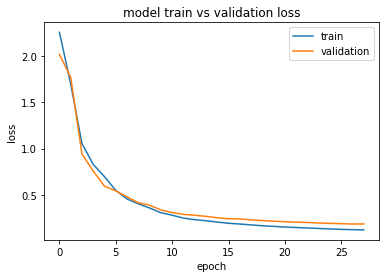

In [0]:
input_dim = D2_scaled.shape[1]
encoding_dim = pca.n_components_  
input_data = Input(shape=(input_dim,))

# hidden layer using number of neurons = number of components
encoded = Dense(encoding_dim, activation='linear')(input_data)

# output layer
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_data, decoded)
esCallback = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=0,
                             verbose=0,
                             mode='min')
autoencoder.compile(optimizer='adam', loss='mse')

print("AUTOENCODER STRUCTURE:")
print(autoencoder.summary())

# train data is X
history = autoencoder.fit(D2_scaled, D2_scaled,
                epochs=100,
                shuffle=True,
                validation_split=0.2,
                verbose = 1,
                callbacks = [esCallback])

 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()




In [0]:
# use the encoded layer to encode the training input
encoder = Model(input_data, encoded)
print("ENCODER STRUCTURE:")
print(encoder.summary())

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))
print("DECODER STRUCTURE:")
print(decoder.summary())

encoded_data = encoder.predict(D2_scaled)
decoded_data = decoder.predict(encoded_data)

ENCODER STRUCTURE:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 252340)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)                21448985  
Total params: 21,448,985
Trainable params: 21,448,985
Non-trainable params: 0
_________________________________________________________________
None
DECODER STRUCTURE:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 85)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 252340)            21701240  
Total params: 21,701,240
Trainable params: 21,701,240
Non-trainable params: 0
_________________________________________

In [0]:
print(D2_scaled.shape, decoded_data.shape)

mse = mean_squared_error(D2_scaled, decoded_data)
print("RMSE = ", np.sqrt(mse))

(240, 252340) (240, 252340)
RMSE =  0.35925970774173205


AUTOENCODER STRUCTURE:
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 252340)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 85)                21448985  
_________________________________________________________________
dense_6 (Dense)              (None, 252340)            21701240  
Total params: 43,150,225
Trainable params: 43,150,225
Non-trainable params: 0
_________________________________________________________________
None
Train on 192 samples, validate on 48 samples
Epoch 1/100
192/192 [==============================] - 1s 8ms/step - loss: 0.9581 - val_loss: 0.9665
Epoch 2/100
192/192 [==============================] - 1s 4ms/step - loss: 0.8386 - val_loss: 0.8455
Epoch 3/100
192/192 [==============================] - 1s 4ms/step - loss: 0.7430 - val_loss: 0.7672
E

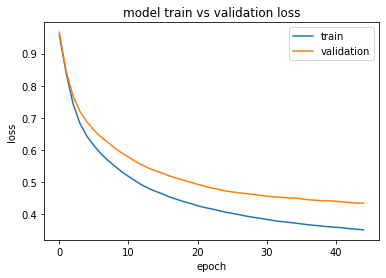

In [11]:
input_dim = D2_scaled.shape[1]
encoding_dim = pca.n_components_  
input_data = Input(shape=(input_dim,))

# hidden layer using number of neurons = number of components
encoded = Dense(encoding_dim, activation='tanh')(input_data)

# output layer
decoded = Dense(input_dim, activation='tanh')(encoded)

autoencoder = Model(input_data, decoded)
esCallback = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=0,
                             verbose=0,
                             mode='min')
autoencoder.compile(optimizer='adam', loss='mse')

print("AUTOENCODER STRUCTURE:")
print(autoencoder.summary())

# train data is X
history = autoencoder.fit(D2_scaled, D2_scaled,
                epochs=100,
                shuffle=True,
                validation_split=0.2,
                verbose = 1,
                callbacks = [esCallback])

 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()




In [12]:
# use the encoded layer to encode the training input
encoder = Model(input_data, encoded)
print("ENCODER STRUCTURE:")
print(encoder.summary())

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))
print("DECODER STRUCTURE:")
print(decoder.summary())

encoded_data = encoder.predict(D2_scaled)
decoded_data = decoder.predict(encoded_data)

ENCODER STRUCTURE:
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 252340)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 85)                21448985  
Total params: 21,448,985
Trainable params: 21,448,985
Non-trainable params: 0
_________________________________________________________________
None
DECODER STRUCTURE:
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 85)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 252340)            21701240  
Total params: 21,701,240
Trainable params: 21,701,240
Non-trainable params: 0
_________________________________________

In [13]:
print(D2_scaled.shape, decoded_data.shape)

mse = mean_squared_error(D2_scaled, decoded_data)
print("RMSE = ", np.sqrt(mse))

(240, 252340) (240, 252340)
RMSE =  0.6059370861927666
